# Generating Fake Medical History for Aim 3 Regression
- Our three medical diagnoses we're checking for (ICD-9-CM / ICD-10-CM): 
  1. Blood Cancers: (200–208 / C81–C96)
  1. Type 1 Diabetes: (250.x1 / E10)
  1. Pediatric Vasculitis: (287, 446 / D69, M30–31)

- Consider also checking for respiratory outcomes. Even though this isn't the focus of our study, but we can check for this outcome as a quality check to make sure we at least find significance there. 

In [44]:
# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# local or gdrive
path_source = 'gdrive'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data/joined_data'
  #env_path = '/content/gdrive/MyDrive/.env'

Mounted at /content/gdrive


In [6]:
# load full dataset
df = pd.read_parquet(os.path.join(data_path, 'joined_open_schools_only_10-10-22.parquet'))

In [7]:
# get every distinct month and zip code that we need health data for:
df.head(3)

,year,cdscode,school_county,school_zip,school_open_date,school_closed_date,school_lat,school_lon,school_wspd,school_elevation_m,year_month,total_population,total_population_male,total_population_female,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,pop_under19_male,pop_under19_female,total_pop_under19,pm25,point_source_lat,point_source_lon,ps_elevation_m,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wind_lat,ps_wind_lon,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,new_year,open_close_dates_valid,Taxable Year,Zip Code,CA_AGI_per_returns,Total Tax Liability,school_county_v2,school_region_name,nearby_point_source_count,open_dates_valid
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2010.0,20102070109728,Madera,93610,2005-08-16,2014-06-30,37.115210,-120.26603,1.531352,70.84,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.0,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968,2010-01-01,1,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1
1,2010.0,20102072030187,Madera,93610,2001-01-22,2014-06-30,37.115210,-120.26603,1.531352,70.84,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.0,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968,2010-01-01,1,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1
2,2010.0,20651930000000,Madera,93610,1990-01-01,2025-01-01,37.122449,-120.26487,1.531352,72.77,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.0,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2358.38241919395,-37.54028477906731,NaN,NaN,1.531352,102.528057,102.528057,140.068342,140.068342,1.531352,140.068342,0.233189,2010-01-01,0,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,0.0,1


In [12]:
df2 = df[['school_zip', 'year_month']].drop_duplicates().reset_index(drop=True)
df2

,school_zip,year_month
0,93610,2010-04-01
1,93505,2010-04-01
2,93238,2010-04-01
3,93226,2010-04-01
4,93249,2010-04-01
...,...,...
329533,96145,2005-03-01
329534,96150,2005-03-01
329535,96145,2016-06-01
329536,96143,2016-06-01


### Quality Checks

In [15]:
# Most zips are listed 240 times, once for each month.
# But some zips appear less frequently.
# I spot checked one of the school_zips with less obs it has a narrow open/closed date. 
# df[df['school_zip'] == 90056]
df2.value_counts(['school_zip'])


# some of the year_month combos have less obs because of the fewer zips issue. Primarily for the early 2000 years. 
df2.value_counts('year_month')

year_month
2011-05-01    1384
2011-04-01    1384
2011-03-01    1384
2011-02-01    1384
2011-01-01    1384
              ... 
2000-05-01    1361
2000-03-01    1360
2000-02-01    1360
2000-04-01    1360
2000-01-01    1360
Length: 240, dtype: int64

# Generate fake medical obs

In [69]:
np.random.seed(123)

# literally just making these up
blood_cancer = np.random.normal(loc=10, scale=2, size=df2.shape[0]) / 1e4 # loc=mean, scale=sd
#type1_diabetes = np.random.poisson(lam=10, size=df2.shape[0]) / 1e3
type1_diabetes = np.random.exponential(10, size=df2.shape[0]) / 1e4
vasculitis = np.random.gamma(shape=2, scale=2, size=df2.shape[0]) / 1e4
respiratory = np.random.normal(loc=10, scale=4, size=df2.shape[0]) / 1e4


# add to the df
df2['blood_cancer'] = np.maximum(0, blood_cancer)
df2['type1_diabetes'] = np.maximum(0, type1_diabetes)
df2['vasculitis'] = np.maximum(0, vasculitis)
df2['respiratory'] = np.maximum(0, respiratory)

In [70]:
df3 = pd.melt(df2, 
              value_vars=['blood_cancer', 'type1_diabetes', 'vasculitis', 'respiratory'], 
              var_name='disease', value_name='proportion')
df3

,disease,proportion
0,blood_cancer,0.000783
1,blood_cancer,0.001199
2,blood_cancer,0.001057
3,blood_cancer,0.000699
4,blood_cancer,0.000884
...,...,...
1318147,respiratory,0.000801
1318148,respiratory,0.001515
1318149,respiratory,0.000265
1318150,respiratory,0.000614


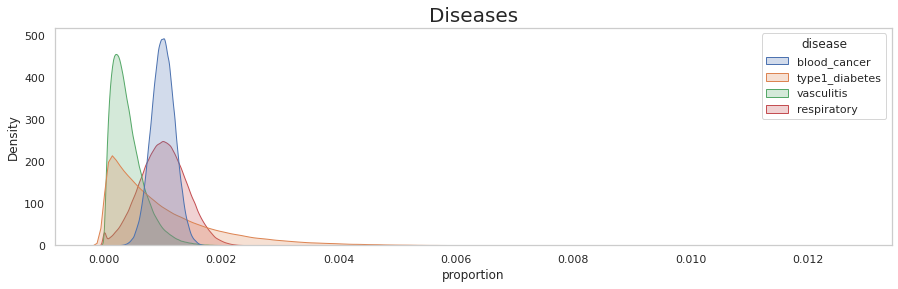

In [71]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df3, x="proportion", hue='disease', bw_adjust=.8, fill=True).set_title("Diseases", size=20)
print('')

# Write data to disk

In [80]:
# df2.to_csv(os.path.join(data_path, '../medical/fake_medical_data.csv')) # csv takes up 35mb of storage
df2.to_parquet(os.path.join(data_path, '../medical/fake_medical_data.parquet')) # parquet takes up 11.8mb of storage